In [76]:
import numpy as np
import matplotlib.pyplot as plt

In [77]:
### Set parameters

n = 10   # number of qubits
N = 2**n    # number of grid points
n_s = 2**(n-4)  # Plot N/n_s number of arrows
dx = 1 / (N-1)  # finite space
dt = 0.00001  # finite time
x = np.linspace(0, 1-dx, N)
y = np.linspace(0, 1-dx, N)
X, Y = np.meshgrid(x, y)
u_0 = 1 # initial velocity
Re = 10
L_box = 1   # domain size
y_min = 0.4
y_max = 0.6
h = 1/200 
n_steps = 100
n_p = 50
#dx = x[1]-x[0]

### Set initial conditions for a 2D developing jet

In [78]:
def J(X, Y, u_0, y_min=0.4, y_max=0.6, h = 0.005):
    return u_0/2*(np.tanh((Y-y_min)/h)-np.tanh((Y-y_max)/h)-1), np.zeros_like(Y)

In [79]:
def d_1(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return 2*L_box/h**2*((Y-y_max)*np.exp(-(Y-y_max)**2/h**2)+(Y-y_min)*np.exp(-(Y-y_min)**2/h**2))*(np.sin(8*np.pi*X/L_box)+np.sin(24*np.pi*X/L_box)+np.sin(6*np.pi*X/L_box))
def d_2(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return np.pi*(np.exp(-(Y-y_max)**2/h**2)+np.exp(-(Y-y_min)**2/h**2))*(8*np.cos(8*np.pi*X/L_box)+24*np.cos(24*np.pi*X/L_box)+6*np.cos(6*np.pi*X/L_box))

In [80]:
def D(X, Y, y_min, y_max, h, L_box):
    d1 = d_1(X, Y, y_min, y_max, h, L_box)
    d2 = d_2(X, Y, y_min, y_max, h, L_box)
    delta = u_0/(40*np.max(np.sqrt(d1**2+d2**2)))
    return delta*d1, delta*d2

(0.0, 1.0)

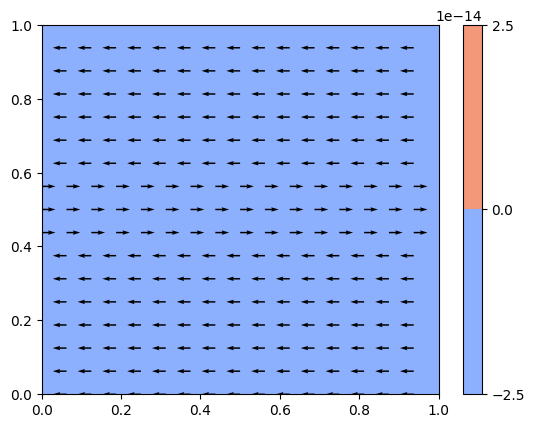

In [81]:
U, V = J(X, Y, u_0, y_min, y_max, h)
dU, dV = D(X, Y, y_min, y_max, h, L_box)
u = U + dU
v = V + dV
p = np.zeros_like(v)
u_star = np.zeros_like(v)
v_star = np.zeros_like(v)
# plt.quiver(X, Y, U, V)
plt.figure()
plt.contourf(X, Y, p, cmap="coolwarm")
plt.colorbar()

plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u[::n_s, ::n_s], v[::n_s, ::n_s], color="black")
# plt.streamplot(X[::2, ::2], Y[::2, ::2], u_prev[::2, ::2], v_prev[::2, ::2], color="black")
plt.xlim((0, 1))
plt.ylim((0, 1))

### Define differentiation methods

In [82]:
def central_difference_1_2_x(f):
    diff = np.zeros_like(f)
    diff = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dx)
    return diff

def central_difference_1_2_y(f):
    diff = np.zeros_like(f)
    diff = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dx)
    return diff

def central_difference_1_8_x(f):
    coeffs = np.array([4/5, -1/5, 4/105, -1/280]) / dx
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) - np.roll(f, i+1, axis=1)) 
    return diff

def central_difference_1_8_y(f):
    coeffs = np.array([4/5, -1/5, 4/105, -1/280]) / dx
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) - np.roll(f, i+1, axis=0)) 
    return diff

def central_difference_x(f):
    return central_difference_1_8_x(f)

def central_difference_y(f):
    return central_difference_1_8_y(f)

def central_difference_2_8_x(f):
    coeffs = np.array([8/5, -1/5, 8/315, -1/560]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) + np.roll(f, i+1, axis=1)) 
    diff += -205/72*f/dx**2
    return diff

def central_difference_2_2_x(f):
    coeffs = np.array([1]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        print(coeff)
        diff += coeff * (np.roll(f, -i-1, axis=1) + np.roll(f, i+1, axis=1)) 
    diff += -2*f/dx**2
    return diff

def central_difference_2_8_y(f):
    coeffs = np.array([8/5, -1/5, 8/315, -1/560]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) + np.roll(f, i+1, axis=0)) 
    diff += -205/72*f/dx**2
    return diff

def laplace(f):
    diff = np.zeros_like(f)
    diff = central_difference_2_8_x(f) + central_difference_2_8_y(f)
    return diff

In [83]:
def get_derivatives(u_temp, v_temp):
    du_dx = central_difference_x(u_temp)
    dv_dx = central_difference_x(v_temp)
    du_dy = central_difference_y(u_temp)
    dv_dy = central_difference_y(v_temp)
    laplace_u = laplace(u_temp)
    laplace_v = laplace(v_temp)

    return du_dx, dv_dx, du_dy, dv_dy, laplace_u, laplace_v

In [84]:
def solve_poisson(rhs, p_prev):
    for _ in range(n_p):
        p_res = p_prev
        p_next = np.zeros_like(p_res)
        p_next = 1/4 * (np.roll(p_res, -1, axis=1) + np.roll(p_res, -1, axis=0) + np.roll(p_res, 1, axis=1) + np.roll(p_res, 1, axis=0) - dx**2 *rhs)
        #coeffs = [8/5, -1/5, 8/315, -1/560]
        #p_next = -72/205 * dx**2 * rhs
        #for i, coeff in enumerate(coeffs):
        #    p_next += 72/205 * coeff * (np.roll(p_res, -i-1, axis=1) + np.roll(p_res, -i-1, axis=0) + np.roll(p_res, i+1, axis=1) + np.roll(p_res, i+1, axis=0))
        p_res = p_next
    
    return p_res

In [85]:
def solve_poisson_fft(rhs):
    F = np.fft.fft2(rhs)

    # get the wavenumbers -- we need these to be physical, so divide by dx
    kx = np.fft.fftfreq(N)/dx
    ky = np.fft.fftfreq(N)/dx

    # make 2-d arrays for the wavenumbers
    kx2d = np.repeat(kx, N)
    kx2d.shape = (N, N)

    ky2d = np.repeat(ky, N)
    ky2d.shape = (N, N)
    ky2d = np.transpose(ky2d)

    # here the FFT frequencies are in the order 0 ... N/2-1, -N/2, ...
    # the 0 component is not a physical frequency, but rather it is
    # the DC signal.  Don't mess with it, since we'll divide by zero
    oldDC = F[0,0]
    F = 0.5*F/( (np.cos(2.0*np.pi*kx2d/N) - 1.0)/dx**2 +
                (np.cos(2.0*np.pi*ky2d/N) - 1.0)/dx**2)

    F[0,0] = oldDC

    # transform back to real space
    fsolution = np.real(np.fft.ifft2(F))

    return fsolution

In [86]:
def solve_poisson_fft_(rhs):
    F = np.fft.fft2(rhs)
    P = np.zeros_like(F)
    oldDC = P[0, 0]
    for i in range(N):
        for j in range(N):
            P[i, j] = - F[i, j] / (4 * (np.sin(np.pi*i/N)**2 + np.sin(np.pi*j/N)**2))
    P[0, 0] = oldDC
    p_res = np.real(np.fft.ifft2(P))

    return p_res

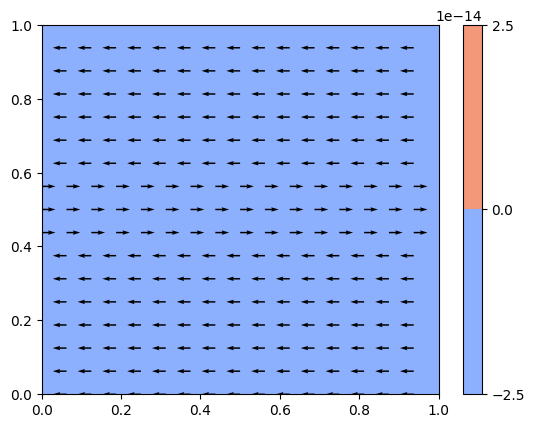

/var/folders/w9/kzh7c_j13zd3x0628855v799j6by0x/T/ipykernel_96755/1732746376.py:20: RuntimeWarning: divide by zero encountered in divide
  F = 0.5*F/( (np.cos(2.0*np.pi*kx2d/N) - 1.0)/dx**2 +
/var/folders/w9/kzh7c_j13zd3x0628855v799j6by0x/T/ipykernel_96755/1732746376.py:20: RuntimeWarning: invalid value encountered in divide
  F = 0.5*F/( (np.cos(2.0*np.pi*kx2d/N) - 1.0)/dx**2 +


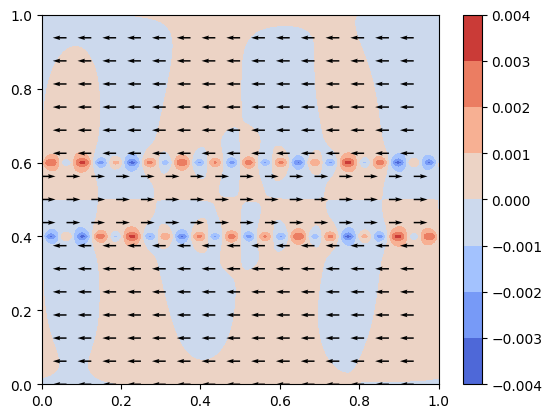

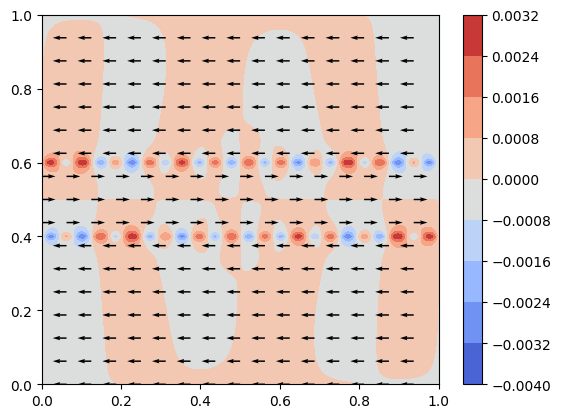

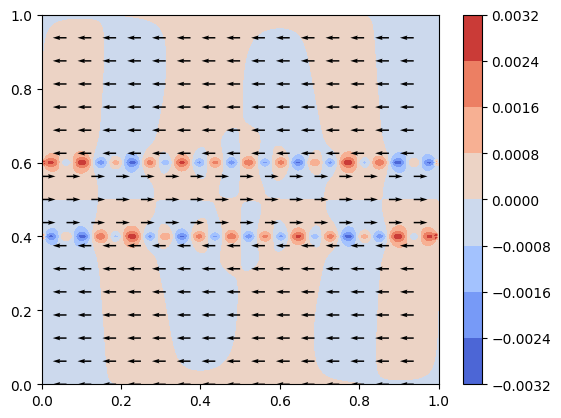

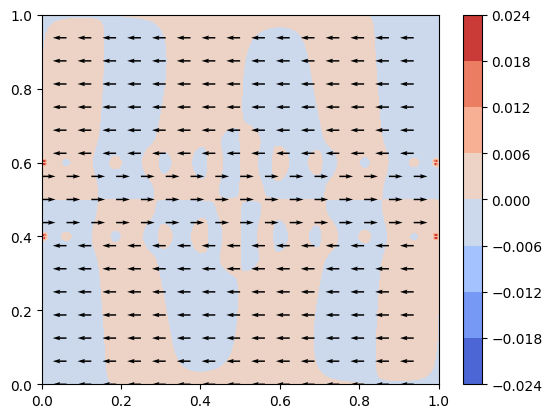

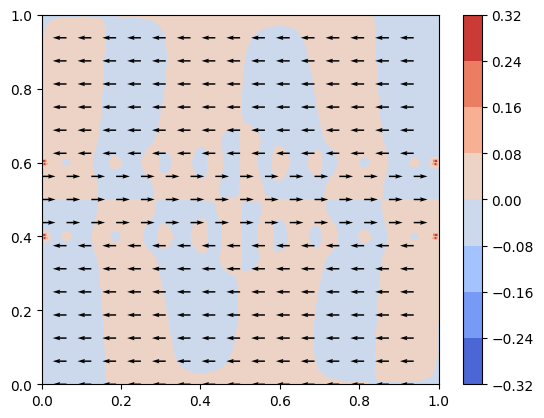

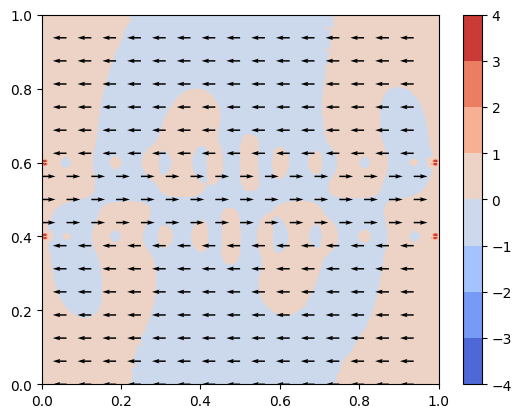

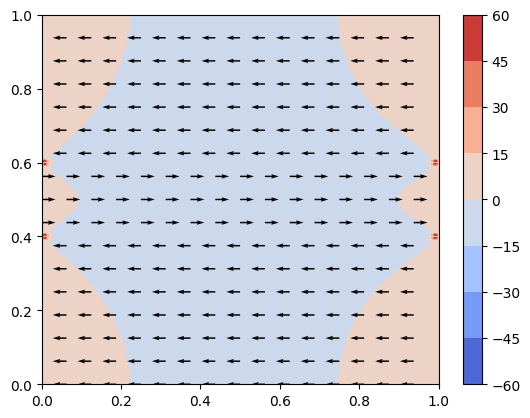

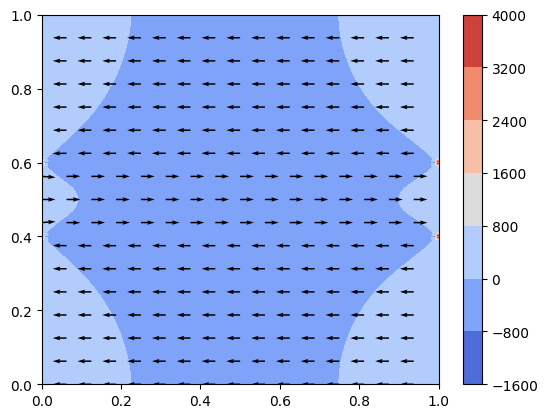

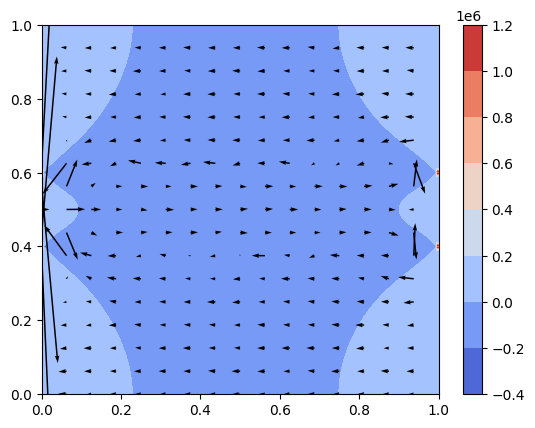

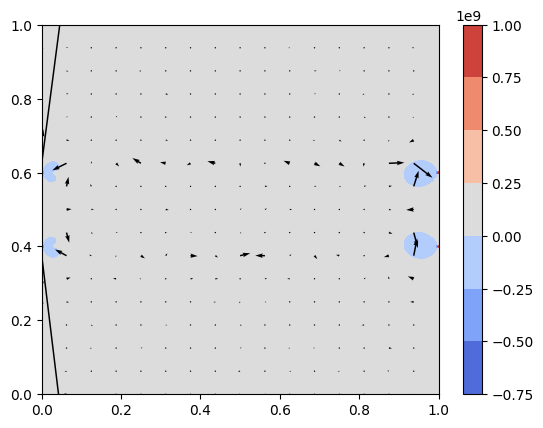

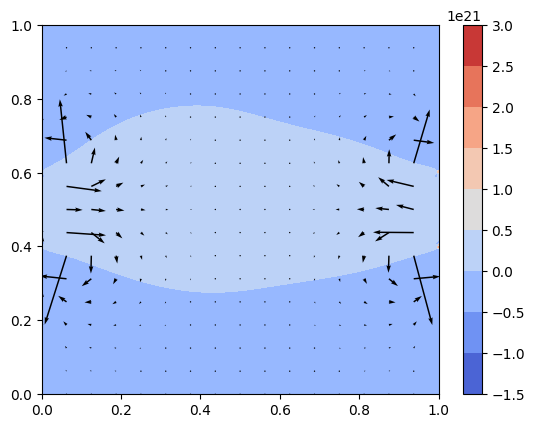

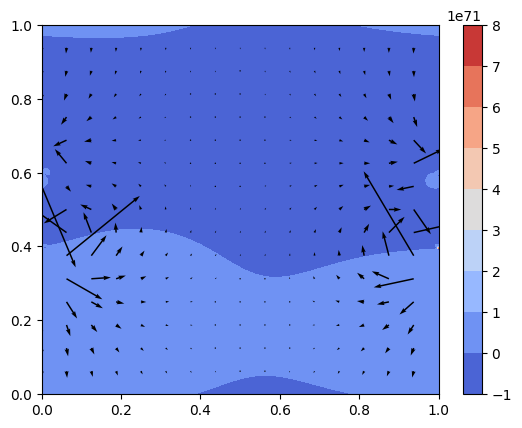

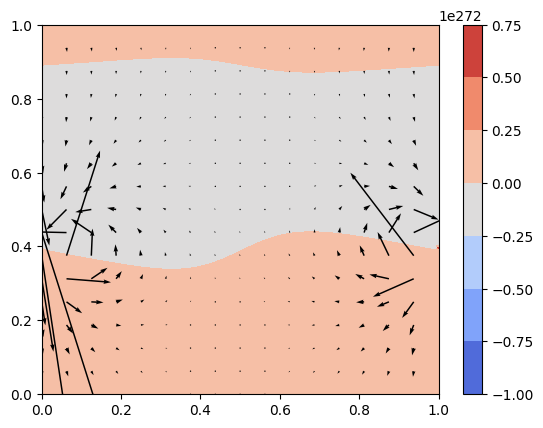

/var/folders/w9/kzh7c_j13zd3x0628855v799j6by0x/T/ipykernel_96755/3587893143.py:20: RuntimeWarning: overflow encountered in multiply
  R_u = (-(u*du_dx + v*du_dy) + laplace_u/Re)
/var/folders/w9/kzh7c_j13zd3x0628855v799j6by0x/T/ipykernel_96755/3587893143.py:20: RuntimeWarning: invalid value encountered in add
  R_u = (-(u*du_dx + v*du_dy) + laplace_u/Re)
/var/folders/w9/kzh7c_j13zd3x0628855v799j6by0x/T/ipykernel_96755/3587893143.py:21: RuntimeWarning: overflow encountered in multiply
  R_v = (-(u*dv_dx + v*dv_dy) + laplace_v/Re)
/var/folders/w9/kzh7c_j13zd3x0628855v799j6by0x/T/ipykernel_96755/3587893143.py:21: RuntimeWarning: invalid value encountered in add
  R_v = (-(u*dv_dx + v*dv_dy) + laplace_v/Re)
/var/folders/w9/kzh7c_j13zd3x0628855v799j6by0x/T/ipykernel_96755/4163892998.py:15: RuntimeWarning: invalid value encountered in subtract
  diff += coeff * (np.roll(f, -i-1, axis=1) - np.roll(f, i+1, axis=1))
/var/folders/w9/kzh7c_j13zd3x0628855v799j6by0x/T/ipykernel_96755/4163892998.py:1

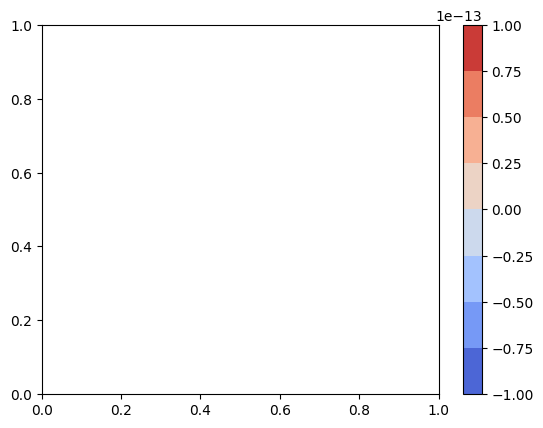

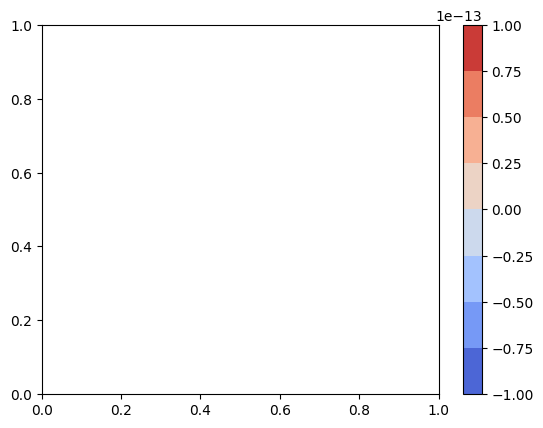

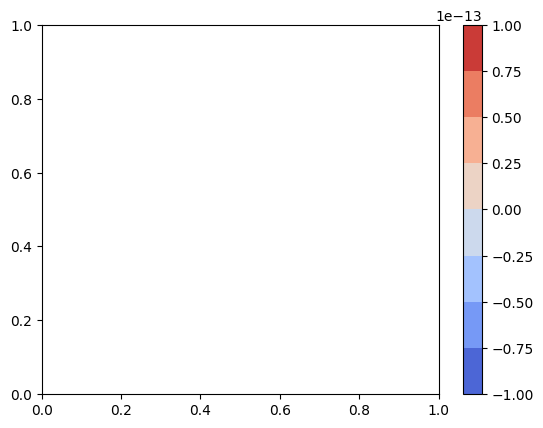

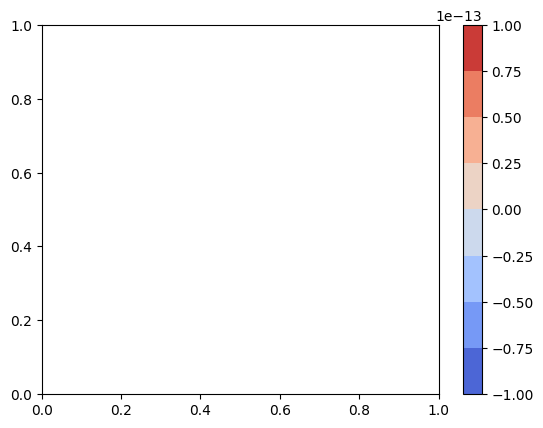

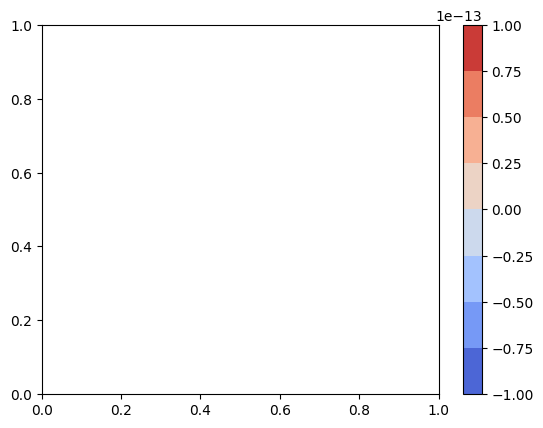

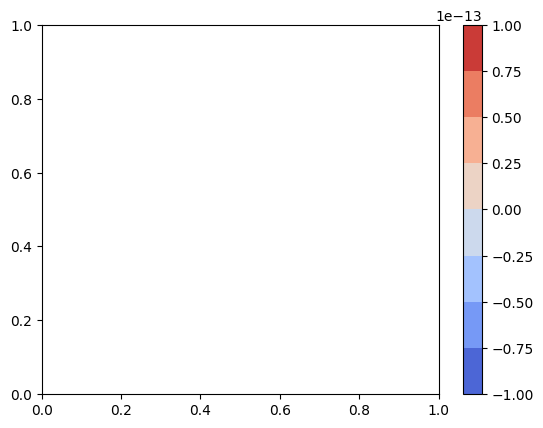

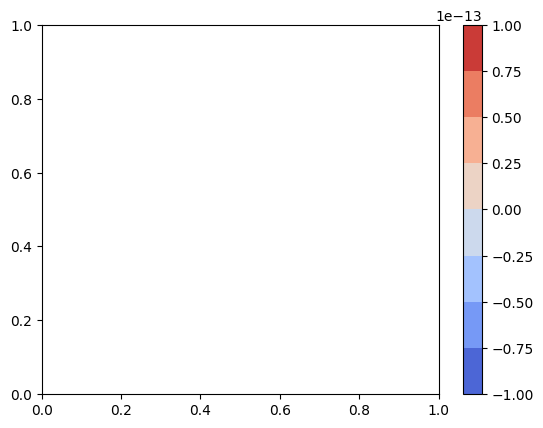

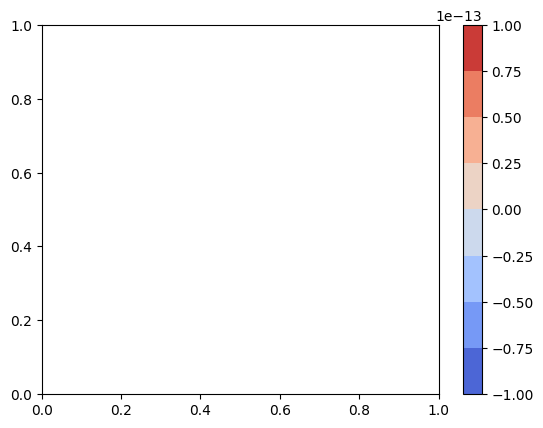

KeyboardInterrupt: 

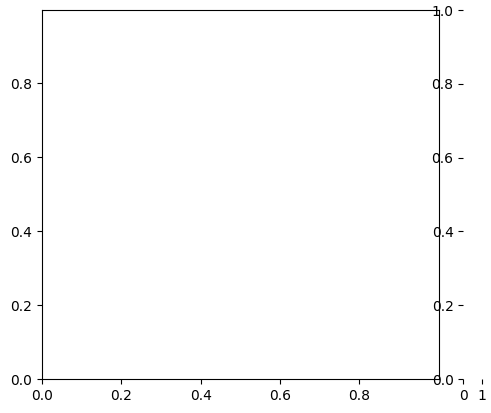

In [87]:
for step in range(n_steps):
    ## Plot before step
    if step%1 == 0:
        plt.figure()
        plt.contourf(X, Y, p, cmap="coolwarm")
        plt.colorbar()

        plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u[::n_s, ::n_s], v[::n_s, ::n_s], color="black")
        plt.xlim((0, 1))
        plt.ylim((0, 1))
    plt.show()

    ## First RK step - calculate k1
    du_dx, dv_dx, du_dy, dv_dy, laplace_u, laplace_v = get_derivatives(u, v)
    u_star = np.zeros_like(u)
    v_star = np.zeros_like(v)
    R_u = np.zeros_like(u)
    R_v = np.zeros_like(v)

    R_u = (-(u*du_dx + v*du_dy) + laplace_u/Re)
    R_v = (-(u*dv_dx + v*dv_dy) + laplace_v/Re)
    u_star = u + dt * R_u
    v_star = v + dt * R_v

    # solve poisson equation
    rhs = (central_difference_x(u_star) + central_difference_y(v_star)) / dt
    p_1 = solve_poisson_fft(rhs)

    # calculate k1
    k1_x = R_u - central_difference_x(p_1)
    k1_y = R_v - central_difference_y(p_1)

    ## Second RK step - calculate velocities and pressure
    u_RK = u + dt/2 * k1_x
    v_RK = v + dt/2 * k1_y
    du_dx, dv_dx, du_dy, dv_dy, laplace_u, laplace_v = get_derivatives(u_RK, v_RK)
    u_star = np.zeros_like(u)
    v_star = np.zeros_like(v)

    u_star = u + dt * (-(u_RK*du_dx + v_RK*du_dy) + laplace_u/Re)
    v_star = v + dt * (-(u_RK*dv_dx + v_RK*dv_dy) + laplace_v/Re)

    # solve poisson equation
    rhs = (central_difference_x(u_star) + central_difference_y(v_star)) / dt
    p = solve_poisson_fft(rhs)

    # calculate velocities
    u = u_star - dt * central_difference_x(p)
    v = v_star - dt * central_difference_y(p)